In [14]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import sktime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

from tsai.basics import timer
# from tsai.data.core import TSDatasets
# from fastai.data.transforms import Categorize
# from tsai.data.validation import combine_split_data
from tsai.data.external import get_UCR_data, get_Monash_regression_data, check_data
from tsai.models.MINIROCKET import *

In [2]:
warnings.filterwarnings(action='ignore', category=UserWarning)

df = pd.read_excel('./DATASET.xlsx')
df.rename(columns={'Unnamed: 0':'Section'}, inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Section  101 non-null    object 
 1   year     1009 non-null   int64  
 2   Para-1   1009 non-null   float64
 3   Para-2   1009 non-null   float64
 4   Para-3   1009 non-null   float64
 5   Para-4   1009 non-null   float64
 6   Para-5   1009 non-null   int64  
 7   Para-6   1009 non-null   int64  
 8   Para-7   1009 non-null   int64  
 9   Para-8   1009 non-null   int64  
 10  Para-9   1009 non-null   float64
 11  Para-10  1009 non-null   float64
 12  Para-11  1009 non-null   float64
 13  Para-12  1009 non-null   int64  
 14  Para-13  1007 non-null   float64
dtypes: float64(8), int64(6), object(1)
memory usage: 118.4+ KB
None


In [3]:
def check_null(df):
    null_entries = df.loc[:,'year':].isnull().any()
    return df.loc[:,'year':].columns[null_entries].tolist()

In [4]:
def get_selected_parameters(x, y, parameters=[8, 9, 10, 11, 12]):
    new_x, new_y = [], []
    for x_vals in x:
        new_x.append(x_vals[parameters])
    for y_vals in y:
        new_y.append(y_vals[parameters])
    new_x = np.array(new_x)
    new_y = np.array(new_y)
    if new_y.dtype == 'object':
        new_y = new_y.astype('float64')
    return new_x, new_y 
    

In [5]:
null_colmns = check_null(df)
print(f'Null Columns: {null_colmns}')
if len(null_colmns)>0:
    print('Filling Null Values')
    [df[col].fillna(method='bfill',inplace=True) for col in null_colmns]

Null Columns: ['Para-13']
Filling Null Values


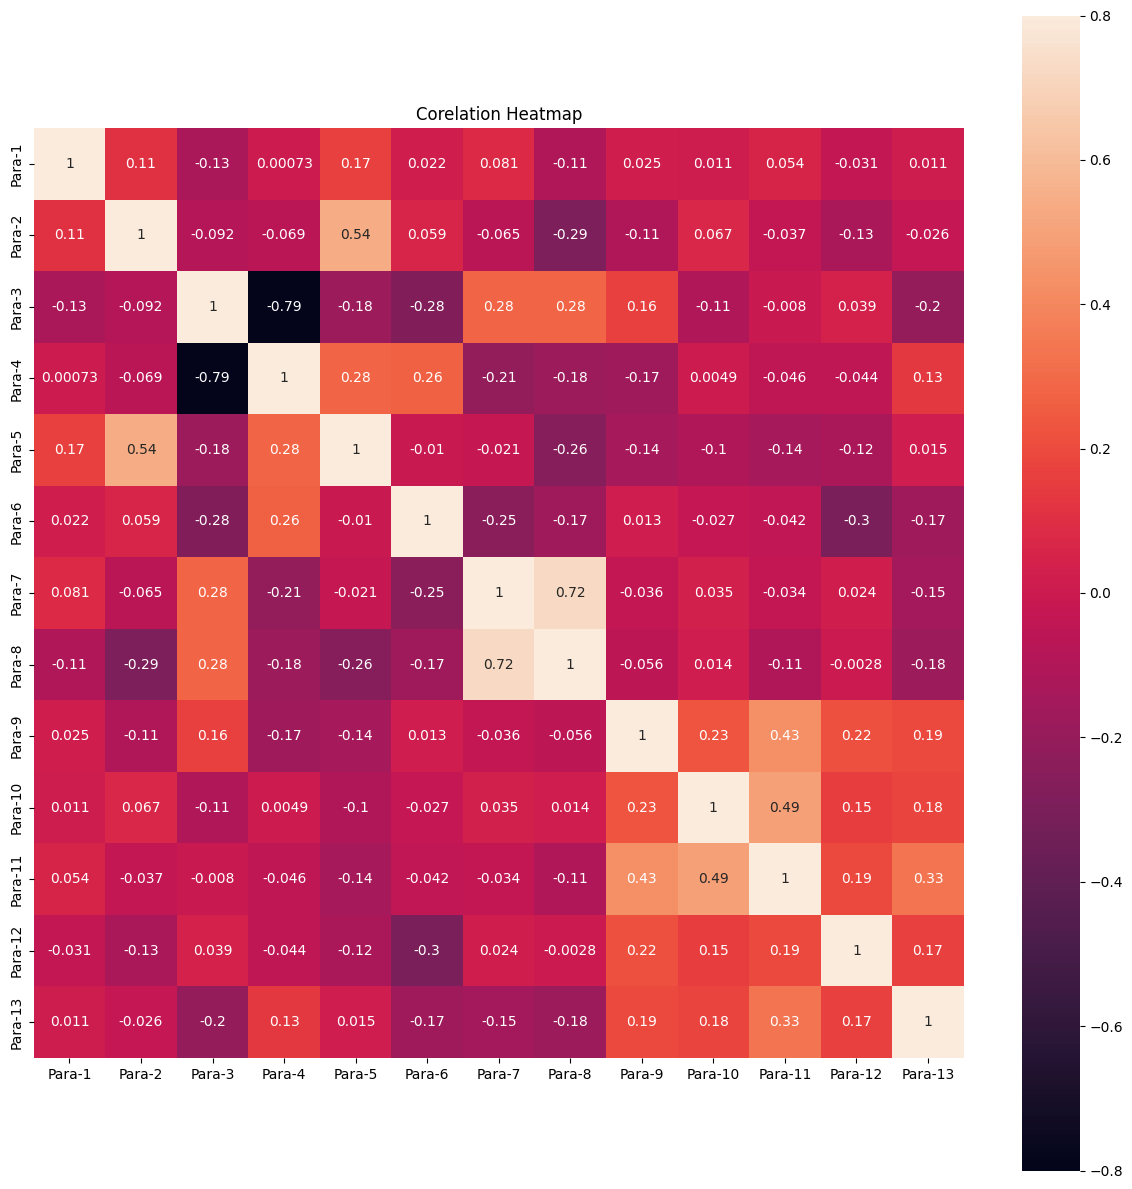

In [59]:
C_mat = df.loc[:,'Para-1':].corr()
fig = plt.figure(figsize = (15,15))
plt.title('Corelation Heatmap')
sns.heatmap(C_mat, vmax = 0.8, vmin = -0.8,  square = True, annot=True)
plt.show()

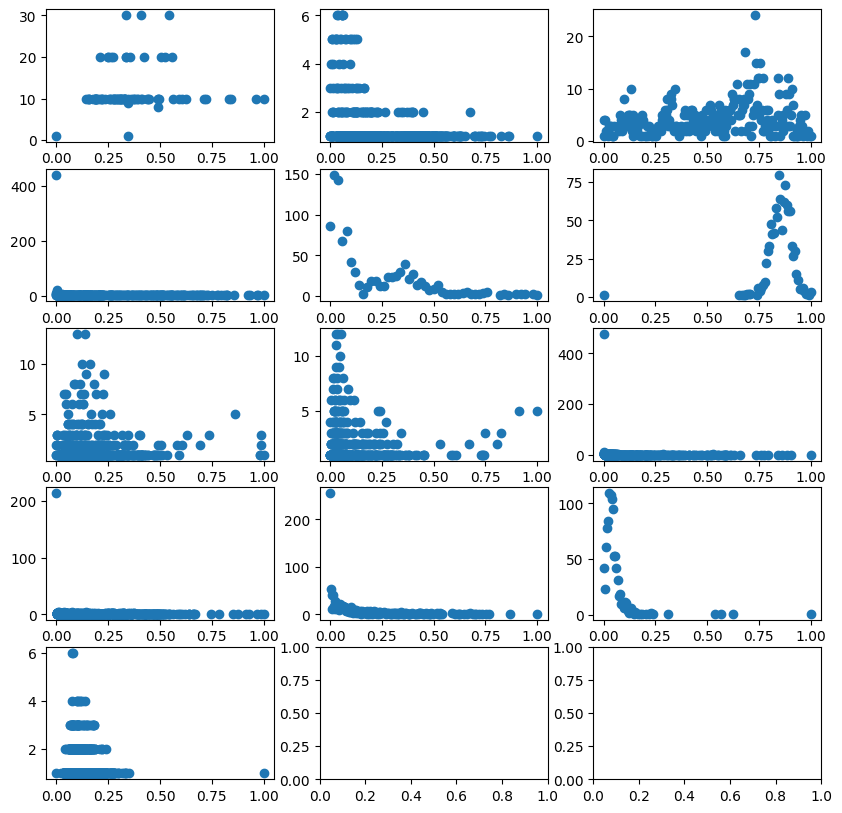

In [60]:
fig, axs = plt.subplots(5, 3, figsize=(10,10))
x, y = 0,-1
for i in range(13):
    x = i//3
    y = i%3
    col = df.columns[i+2]
    axs[x,y].scatter(df[col].value_counts().index, df[col].value_counts())

In [35]:
print('Scaling attributes')
scalar = {}
for column in df.columns[2:]:
    scalar[column] = MinMaxScaler()
    df[column] = scalar[column].fit_transform(df[column].values.reshape(-1,1))

Scaling attributes


In [36]:
df['Section'].ffill(inplace=True)
df_sections = df.groupby('Section', dropna=False)

print(f'Grouped dataframe by sections\nDataFrame Size: {len(df)}\nGroups: {len(df_sections)}')

Grouped dataframe by sections
DataFrame Size: 1009
Groups: 101


In [8]:
# dsid = 'LSST'
# X_train, y_train, X_valid, y_valid = get_UCR_data(dsid)
# print(type(X_train))
# print(y_train[0])
# print(X_valid.shape)

# dsid = 'NATOPS' 
# X, y, splits = get_UCR_data(dsid, return_split=False)
# tfms  = [None, [Categorize()]]
# dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# print(dsets)

In [37]:
print('Converting Dataframe to 3d structure:\n1. Samples\n2. Variables\n3. Length')
x_raw, y_raw = [], []
i=0
for section in list(df_sections):
    section[1].reset_index(inplace=True)
    # print(section[1].loc[:8,'Para-1':'Para-7'].T)
    if len(section[1]) == 10:
        x_raw.append(section[1].loc[:8,'Para-1':'Para-13'].T)
        y_raw.append(section[1].loc[9,'Para-1':'Para-13'].T)
x_raw = np.array(x_raw)
y_raw = np.array(y_raw)
if y_raw.dtype == 'object':
    y_raw = y_raw.astype('float64')
print(f'New Shape:\nX: {x_raw.shape}\nY: {y_raw.shape}')

Converting Dataframe to 3d structure:
1. Samples
2. Variables
3. Length
New Shape:
X: (100, 13, 9)
Y: (100, 13)


In [38]:
# X, y, splits = combine_split_data([x_raw], [y_raw])

# check_data(X, y, splits)
# tfms  = [None, [Categorize()]]
# dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

In [47]:
x, y = get_selected_parameters(x_raw, y_raw)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
print('Train test split')

Train test split


In [54]:
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
model = MiniRocketRegressor(scoring=rmse_scorer)
timer.start(False)
model.fit(x_train, y_train)
t = timer.stop()
print(f'Model Trained\nTime: {t}')
y_pred = model.predict(x_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
model.save(f'MRVRegressor_{r2:.10f}')
print('Model saved')

Model Trained
Time: 0:00:00.102970
Model saved


In [55]:
print(f'RMSE : {rmse:.5f}\nR2 : {r2:.5f}')

RMSE : 0.07430
R2 : 0.65672


In [56]:
y_raw_pred = model.predict(x)
r2_total = r2_score(y, y_raw_pred)
print(f'Overall R2 for all values: {r2_total}')

Overall R2 for all values: 0.9714942219950297


In [58]:
print(y_pred, y_test)

[[-0.01400651  0.12641889  0.1163776   0.0305065   0.15543975]
 [ 0.21697072  0.06964927  0.230922    0.1252107   0.2371849 ]
 [ 0.29583895  0.38496747  0.53940927  0.03101865  0.08841216]
 [ 0.62902465  0.62162348  0.56529932  0.10809781  0.21839629]
 [ 0.36955788  0.55627544  0.34009997  0.11347777  0.18635018]
 [ 0.19131843  0.19505698  0.16947662  0.05422658  0.15336596]
 [-0.02024059  0.15074055  0.05004734 -0.00971579  0.13809406]
 [ 0.07310204 -0.01603542  0.0086441  -0.03215538  0.16919827]
 [ 0.14453424  0.47474299  0.12741812  0.04189081  0.02197025]
 [ 0.02207683  0.13456457  0.31268258  0.04201798  0.18176633]
 [ 0.14114317  0.18822143  0.69567227  0.07682855  0.11930328]
 [ 0.24315431  0.52223589  0.20012848  0.08693969  0.1377516 ]
 [ 0.01763558  0.41338939  0.19761557  0.01603436  0.05222205]
 [-0.00330365  0.42621808  0.16840574  0.07690308  0.11619579]
 [ 0.08476397  0.36768702  0.04747129  0.02931451  0.09536457]] [[0.0103609  0.12557152 0.10135135 0.0625     0.155051